In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import LabelEncoder

Mounted at /content/drive


In [3]:
img_width, img_height = 224, 224
batch_size = 32

data_dir = "/content/drive/My Drive/dataset_blood_group"

abo_model_path = "/content/drive/My Drive/blood_group_ABO_resnet.h5"
rh_model_path  = "/content/drive/My Drive/blood_group_Rh_resnet.h5"
encoder_path   = "/content/drive/My Drive/label_encoder.pkl"

history_abo_path = "/content/drive/My Drive/history_abo.pkl"
history_rh_path  = "/content/drive/My Drive/history_rh.pkl"

In [4]:
abo_exists = os.path.exists(abo_model_path)
rh_exists  = os.path.exists(rh_model_path)
hist_exists = os.path.exists(history_abo_path) and os.path.exists(history_rh_path)

if abo_exists and rh_exists and hist_exists:
    print("✅ Loading trained models and history...")
    abo_model = load_model(abo_model_path)
    rh_model  = load_model(rh_model_path)

    with open(history_abo_path, 'rb') as f:
        history_abo = pickle.load(f)
    with open(history_rh_path, 'rb') as f:
        history_rh = pickle.load(f)

else:
    print("🚀 Training Two-Stage Models New...")

    train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=15,
        width_shift_range=0.05, height_shift_range=0.05,
        zoom_range=0.10, horizontal_flip=True,
        brightness_range=[0.85, 1.15], validation_split=0.2
    )

    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = train_datagen.flow_from_directory(
        data_dir, target_size=(224,224),
        batch_size=batch_size, class_mode='categorical', subset='training'
    )

    val_gen = val_datagen.flow_from_directory(
        data_dir, target_size=(224,224),
        batch_size=batch_size, class_mode='categorical', subset='validation'
    )

    classes = list(train_gen.class_indices.keys())
    encoder = LabelEncoder()
    encoder.fit(classes)
    with open(encoder_path, 'wb') as f:
        pickle.dump(encoder, f)

    inv = {v:k for k,v in train_gen.class_indices.items()}

    def get_abo(name): return name.replace("+","").replace("-","")
    def get_rh(name):  return "Positive" if "+" in name else "Negative"

    abo_labels = sorted({get_abo(c) for c in classes})
    rh_labels  = ["Negative","Positive"]

    abo_map = {c:i for i,c in enumerate(abo_labels)}
    rh_map  = {c:i for i,c in enumerate(rh_labels)}

    def abo_generator(gen):
        while True:
            x,y=next(gen)
            idx=np.argmax(y,axis=1)
            new=[abo_map[get_abo(inv[i])] for i in idx]
            yield x, tf.keras.utils.to_categorical(new,len(abo_labels))

    def rh_generator(gen):
        while True:
            x,y=next(gen)
            idx=np.argmax(y,axis=1)
            new=[rh_map[get_rh(inv[i])] for i in idx]
            yield x, tf.keras.utils.to_categorical(new,2)

    train_abo = abo_generator(train_gen)
    val_abo   = abo_generator(val_gen)

    train_rh = rh_generator(train_datagen.flow_from_directory(
        data_dir,target_size=(224,224),batch_size=batch_size,
        class_mode='categorical',subset='training'))

    val_rh = rh_generator(val_datagen.flow_from_directory(
        data_dir,target_size=(224,224),batch_size=batch_size,
        class_mode='categorical',subset='validation'))

    steps_train = len(train_gen)
    steps_val   = len(val_gen)

🚀 Training Two-Stage Models New...
Found 4563 images belonging to 8 classes.
Found 1137 images belonging to 8 classes.
Found 4563 images belonging to 8 classes.
Found 1137 images belonging to 8 classes.


In [5]:
def build_resnet(num_classes, rh=False):
    base = ResNet50(weights="imagenet", include_top=False,
                    input_shape=(224,224,3))

    freeze_until = -40 if rh else -70

    for l in base.layers[:freeze_until]:
        l.trainable = False
    for l in base.layers[freeze_until:]:
        l.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4 if rh else 0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(base.input, out)

    optimizer = tf.keras.optimizers.AdamW(3e-5, weight_decay=1e-4) if rh else tf.keras.optimizers.Adam(1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1) if rh else "categorical_crossentropy"

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [6]:
abo_model = build_resnet(len(abo_labels), rh=False)
history_abo = abo_model.fit(
    train_abo, validation_data=val_abo,
    steps_per_epoch=steps_train,
    validation_steps=steps_val,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3),
        tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/checkpoints/abo.weights.h5",
                                           save_best_only=True, monitor='val_accuracy')
    ]
)

abo_model.save(abo_model_path)

rh_model = build_resnet(2, rh=True)
history_rh = rh_model.fit(
    train_rh, validation_data=val_rh,
    steps_per_epoch=steps_train,
    validation_steps=steps_val,
    epochs=40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.25),
        tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/checkpoints/rh.weights.h5",
                                           save_best_only=True, monitor='val_accuracy')
    ]
)

rh_model.save(rh_model_path)

# ✅ SAVE HISTORY
with open(history_abo_path,'wb') as f: pickle.dump(history_abo.history, f)
with open(history_rh_path,'wb') as f: pickle.dump(history_rh.history, f)

print("✅ Models and history saved.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3115 - loss: 1.4550 

143/143 ━━━━━━━━━━━━━━━━━━━━ 3138s 22s/step - accuracy: 0.3117 - loss: 1.4545 - val_accuracy: 0.2515 - val_loss: 1.4927 - learning_rate: 1.0000e-05
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.4042 - loss: 1.2766

143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 737ms/step - accuracy: 0.4043 - loss: 1.2764 - val_accuracy: 0.4424 - val_loss: 1.2252 - learning_rate: 1.0000e-05
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.4354 - loss: 1.1928

143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.4355 - loss: 1.1926 - val_accuracy: 0.4890 - val_loss: 1.0646 - learning_rate: 1.0000e-05
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.4883 - loss: 1.1018

143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 634ms/step - accuracy: 0.4884 - loss: 1.1017 - val_accuracy: 0.5479 - val_loss: 0.9870 - learning_rate: 1.0000e-05
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.5304 - loss: 1.0183

143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 628ms/step - accuracy: 0.5304 - loss: 1.0183 - val_accuracy: 0.6192 - val_loss: 0.8358 - learning_rate: 1.0000e-05
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.5683 - loss: 0.9846 - val_accuracy: 0.6033 - val_loss: 0.8596 - learning_rate: 1.0000e-05
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 542ms/step - accuracy: 0.5944 - loss: 0.9233 - val_accuracy: 0.5796 - val_loss: 0.9219 - learning_rate: 1.0000e-05
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6100 - loss: 0.9102

143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 591ms/step - accuracy: 0.6100 - loss: 0.9101 - val_accuracy: 0.6368 - val_loss: 0.8641 - learning_rate: 1.0000e-05
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6410 - loss: 0.8195

143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 627ms/step - accuracy: 0.6411 - loss: 0.8193 - val_accuracy: 0.7159 - val_loss: 0.6683 - learning_rate: 3.0000e-06
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 578ms/step - accuracy: 0.6714 - loss: 0.7750 - val_accuracy: 0.7027 - val_loss: 0.6856 - learning_rate: 3.0000e-06
Epoch 11/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6721 - loss: 0.7780

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 584ms/step - accuracy: 0.6722 - loss: 0.7779 - val_accuracy: 0.7194 - val_loss: 0.6711 - learning_rate: 3.0000e-06
Epoch 12/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6740 - loss: 0.7613

143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - accuracy: 0.6741 - loss: 0.7612 - val_accuracy: 0.7309 - val_loss: 0.6465 - learning_rate: 3.0000e-06
Epoch 13/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.6881 - loss: 0.7457 - val_accuracy: 0.7274 - val_loss: 0.6376 - learning_rate: 3.0000e-06
Epoch 14/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6978 - loss: 0.7368

143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 578ms/step - accuracy: 0.6978 - loss: 0.7368 - val_accuracy: 0.7458 - val_loss: 0.6158 - learning_rate: 3.0000e-06
Epoch 15/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7002 - loss: 0.7135

143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 640ms/step - accuracy: 0.7002 - loss: 0.7136 - val_accuracy: 0.7520 - val_loss: 0.6039 - learning_rate: 3.0000e-06
Epoch 16/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 589ms/step - accuracy: 0.7164 - loss: 0.6911 - val_accuracy: 0.7326 - val_loss: 0.6180 - learning_rate: 3.0000e-06
Epoch 17/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.7172 - loss: 0.7018 - val_accuracy: 0.7458 - val_loss: 0.5866 - learning_rate: 3.0000e-06
Epoch 18/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 518ms/step - accuracy: 0.7373 - loss: 0.6640 - val_accuracy: 0.7493 - val_loss: 0.5966 - learning_rate: 3.0000e-06
Epoch 19/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 543ms/step - accuracy: 0.7342 - loss: 0.6633 - val_accuracy: 0.7326 - val_loss: 0.6096 - learning_rate: 3.0000e-06
Epoch 20/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7252 - loss: 0.6680

143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 593ms/step - accuracy: 0.7252 - loss: 0.6680 - val_accuracy: 0.7625 - val_loss: 0.5532 - learning_rate: 3.0000e-06
Epoch 21/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.7370 - loss: 0.6534 - val_accuracy: 0.7432 - val_loss: 0.5922 - learning_rate: 3.0000e-06
Epoch 22/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 542ms/step - accuracy: 0.7348 - loss: 0.6489 - val_accuracy: 0.7564 - val_loss: 0.5637 - learning_rate: 3.0000e-06
Epoch 23/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 575ms/step - accuracy: 0.7437 - loss: 0.6261 - val_accuracy: 0.7555 - val_loss: 0.5672 - learning_rate: 3.0000e-06
Epoch 24/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7480 - loss: 0.6047

143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 558ms/step - accuracy: 0.7480 - loss: 0.6048 - val_accuracy: 0.7792 - val_loss: 0.5224 - learning_rate: 9.0000e-07
Epoch 25/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 573ms/step - accuracy: 0.7467 - loss: 0.6180 - val_accuracy: 0.7740 - val_loss: 0.5404 - learning_rate: 9.0000e-07
Epoch 26/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 546ms/step - accuracy: 0.7583 - loss: 0.5927 - val_accuracy: 0.7766 - val_loss: 0.5226 - learning_rate: 9.0000e-07
Epoch 27/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7630 - loss: 0.5909

143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.7630 - loss: 0.5909 - val_accuracy: 0.7836 - val_loss: 0.5138 - learning_rate: 9.0000e-07
Epoch 28/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 590ms/step - accuracy: 0.7505 - loss: 0.6049 - val_accuracy: 0.7810 - val_loss: 0.5097 - learning_rate: 9.0000e-07
Epoch 29/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7569 - loss: 0.6176

143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 619ms/step - accuracy: 0.7569 - loss: 0.6175 - val_accuracy: 0.7951 - val_loss: 0.5054 - learning_rate: 9.0000e-07
Epoch 30/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.7600 - loss: 0.5968 - val_accuracy: 0.7766 - val_loss: 0.5172 - learning_rate: 9.0000e-07


Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6774 - loss: 0.6248

143/143 ━━━━━━━━━━━━━━━━━━━━ 117s 667ms/step - accuracy: 0.6777 - loss: 0.6244 - val_accuracy: 0.5251 - val_loss: 0.6842 - learning_rate: 3.0000e-05
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7699 - loss: 0.5322

143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 606ms/step - accuracy: 0.7699 - loss: 0.5322 - val_accuracy: 0.7722 - val_loss: 0.5300 - learning_rate: 3.0000e-05
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7942 - loss: 0.5083

143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - accuracy: 0.7943 - loss: 0.5082 - val_accuracy: 0.7880 - val_loss: 0.4953 - learning_rate: 3.0000e-05
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8043 - loss: 0.4954

143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.8043 - loss: 0.4953 - val_accuracy: 0.8584 - val_loss: 0.4201 - learning_rate: 3.0000e-05
Epoch 5/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.8365 - loss: 0.4512 - val_accuracy: 0.8267 - val_loss: 0.4578 - learning_rate: 3.0000e-05
Epoch 6/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8532 - loss: 0.4314

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.8532 - loss: 0.4314 - val_accuracy: 0.8769 - val_loss: 0.4054 - learning_rate: 3.0000e-05
Epoch 7/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 564ms/step - accuracy: 0.8519 - loss: 0.4361 - val_accuracy: 0.8663 - val_loss: 0.4136 - learning_rate: 3.0000e-05
Epoch 8/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8566 - loss: 0.4176

143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 603ms/step - accuracy: 0.8566 - loss: 0.4176 - val_accuracy: 0.8839 - val_loss: 0.3783 - learning_rate: 3.0000e-05
Epoch 9/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 568ms/step - accuracy: 0.8696 - loss: 0.4060 - val_accuracy: 0.8593 - val_loss: 0.4237 - learning_rate: 3.0000e-05
Epoch 10/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8697 - loss: 0.3993

143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 608ms/step - accuracy: 0.8696 - loss: 0.3993 - val_accuracy: 0.8909 - val_loss: 0.3658 - learning_rate: 3.0000e-05
Epoch 11/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 569ms/step - accuracy: 0.8836 - loss: 0.3961 - val_accuracy: 0.8505 - val_loss: 0.4260 - learning_rate: 3.0000e-05
Epoch 12/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 556ms/step - accuracy: 0.8800 - loss: 0.3955 - val_accuracy: 0.8857 - val_loss: 0.3757 - learning_rate: 3.0000e-05
Epoch 13/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 548ms/step - accuracy: 0.8771 - loss: 0.3924 - val_accuracy: 0.8751 - val_loss: 0.3948 - learning_rate: 3.0000e-05
Epoch 14/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8891 - loss: 0.3802

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 585ms/step - accuracy: 0.8891 - loss: 0.3803 - val_accuracy: 0.8918 - val_loss: 0.3719 - learning_rate: 3.0000e-05
Epoch 15/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 596ms/step - accuracy: 0.8984 - loss: 0.3710 - val_accuracy: 0.8874 - val_loss: 0.3760 - learning_rate: 7.5000e-06
Epoch 16/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8950 - loss: 0.3641

143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 607ms/step - accuracy: 0.8950 - loss: 0.3641 - val_accuracy: 0.9200 - val_loss: 0.3407 - learning_rate: 7.5000e-06
Epoch 17/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 603ms/step - accuracy: 0.9024 - loss: 0.3652 - val_accuracy: 0.8962 - val_loss: 0.3675 - learning_rate: 7.5000e-06
Epoch 18/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 539ms/step - accuracy: 0.8889 - loss: 0.3690 - val_accuracy: 0.9138 - val_loss: 0.3503 - learning_rate: 7.5000e-06
Epoch 19/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - accuracy: 0.8858 - loss: 0.3775 - val_accuracy: 0.9077 - val_loss: 0.3502 - learning_rate: 7.5000e-06
Epoch 20/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 515ms/step - accuracy: 0.9083 - loss: 0.3530 - val_accuracy: 0.9059 - val_loss: 0.3414 - learning_rate: 7.5000e-06
Epoch 21/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.9197 - loss: 0.3438 - val_accuracy: 0.8953 - val_loss: 0.3563 - learning_rate: 1.8750e-06
Epoch 22/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/s

✅ Models and history saved.


In [7]:
with open(history_abo_path, 'rb') as f:
    history_abo = pickle.load(f)

with open(history_rh_path, 'rb') as f:
    history_rh = pickle.load(f)

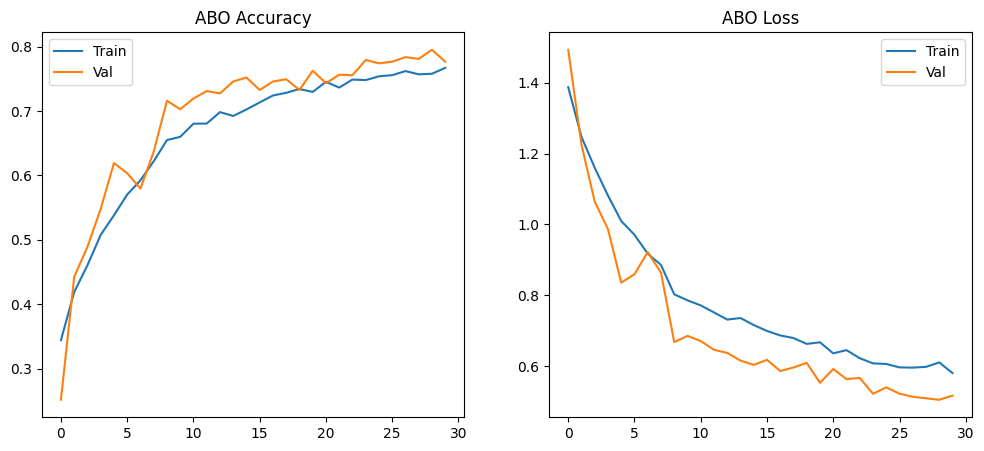

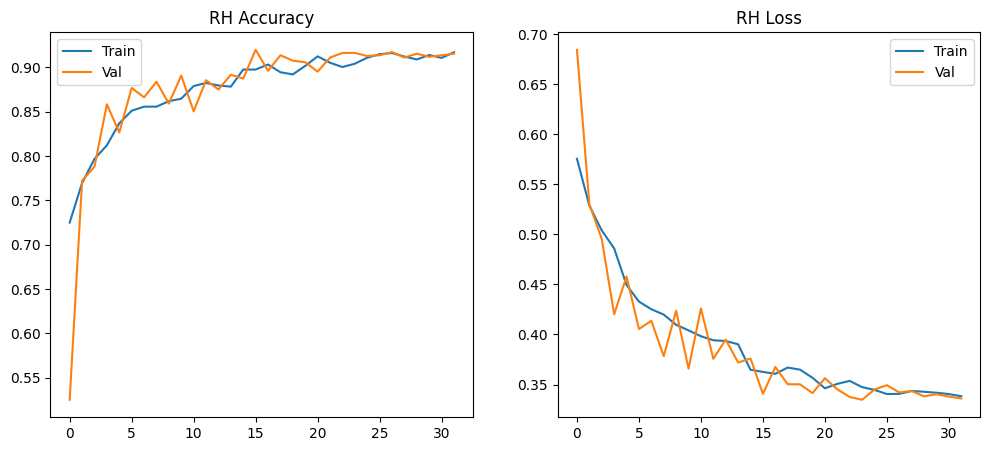

In [8]:
def plot_history(hist, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist['accuracy'],label="Train")
    plt.plot(hist['val_accuracy'],label="Val")
    plt.title(title+" Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist['loss'],label="Train")
    plt.plot(hist['val_loss'],label="Val")
    plt.title(title+" Loss")
    plt.legend()
    plt.show()

plot_history(history_abo, "ABO")
plot_history(history_rh,  "RH")

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Reload validation generator for evaluation
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_indices = val_gen.class_indices
inv_map = {v:k for k,v in class_indices.items()}

Found 5700 images belonging to 8 classes.


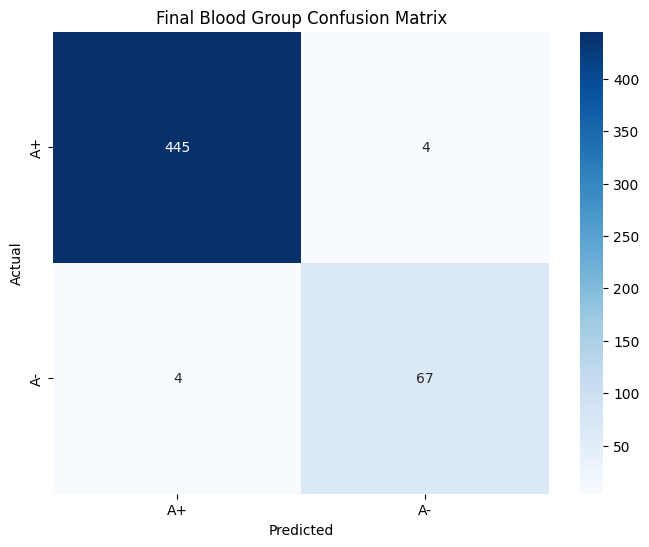

In [15]:
labels = sorted(list(set(y_true)))

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Blood Group Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()
df_report


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
A+,0.991091,0.794643,0.882061,560.000000
A-,0.943662,0.728261,0.822086,92.000000
AB+,0.000000,0.000000,0.000000,0.000000
AB-,0.000000,0.000000,0.000000,0.000000
B+,0.000000,0.000000,0.000000,0.000000
B-,0.000000,0.000000,0.000000,0.000000
O+,0.000000,0.000000,0.000000,0.000000
O-,0.000000,0.000000,0.000000,0.000000
accuracy,0.785276,0.785276,0.785276,0.785276
macro avg,0.241844,0.190363,0.213018,652.000000


from matplotlib import pyplot as plt
_df_0['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [21]:
df_report.to_csv("/content/drive/My Drive/final_results_report.csv")
print("✅ Classification report saved as CSV.")

✅ Classification report saved as CSV.


In [18]:
results_table.to_csv("/content/drive/My Drive/final_accuracy_table.csv", index=False)
print("✅ Accuracy table saved.")

✅ Accuracy table saved.


In [10]:
abo_model = load_model(abo_model_path)
rh_model  = load_model(rh_model_path)
abo_classes = ["A", "AB", "B", "O"]

def predict_blood_group(path):
    img = load_img(path, target_size=(224,224))
    img = img_to_array(img)/255.
    img = np.expand_dims(img,0)

    abo = np.argmax(abo_model.predict(img))
    rh  = np.argmax(rh_model.predict(img))

    return abo_classes[abo] + ("+" if rh==1 else "-")

# Example
img_path = "cluster_5_54.BMP"
print("✅ Prediction:", predict_blood_group(img_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Prediction: AB-
